In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os, sys
from pathlib import Path
from pandarallel import pandarallel

import plotly.express as px
import plotly.graph_objects as go

########   Initialize and setup pandas methods   ########
pandarallel.initialize(nb_workers=os.cpu_count()-1, progress_bar=False, 
                       verbose=2, use_memory_fs=False) 
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../'))

from libs.scoring import Scoring

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
scores = {'clinvar_same_pos': 2,                    #1
          'clinvar_same_motif': 1,                  #2
          'clinvar_else': 0,                        #3 
          'non_canon_splai_gte_0.2': 3,             #4
          'non_canon_splai_bet_0.1_0.2': 1,         #5
          'non_canon_splai_lte_0.1_outside': -1,    #6
          'non_canon_splai_lte_0.1_other': 0,       #7
          'frameshift_nmd_eloF': 6,                 #8
          'frameshift_nmd_not_eloF': 3,             #9
          'canon_strong': 5,                        #10
          'canon_moderate': 4,                      #11
          'canon_splai_lte_0.1': -1,                #12
          'canon_splai_bet_0.1_0.2': 0,             #13
          'canon_splai_gte_0.2': 1,                 #14
          }

In [7]:

scoring = Scoring(ths=scores)

df = pd.read_pickle('../TP/tp_prescore.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tp = scoring.calc_priority_score(df)

df = pd.read_pickle('../TN/tn_prescore.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tn = scoring.calc_priority_score(df)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [8]:
# Load the data
# TP_pickle = '../TP/tp_final.rev2.pkl'
# TN_pickle = '../TN/tn_final.rev2.pkl'

# tp = pd.read_pickle(TP_pickle)
# tn = pd.read_pickle(TN_pickle)

# Exclude Y chromosome
tn = tn[tn['CHROM'] != 'Y']
print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

# Add label
tp.loc[:, 'LABEL'] = 1
tn.loc[:, 'LABEL'] = 0

# Extract the columns needed
tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

# Combine tp and tn
data = pd.concat([tp, tn], ignore_index=True)

print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

Samples in TP: 10387  Samples in TN: 47342
0 0


/var/folders/b_/1qjd6n853xbbctck9_20_nt40000gn/T/ipykernel_55192/2603737134.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
data['PriorityScore'] 

0        5
1        4
2        3
3        4
4        4
        ..
57724    0
57725    0
57726    0
57727    0
57728    0
Name: PriorityScore, Length: 57729, dtype: int64

In [10]:
def specificity_sensitivity_plotly(data):
    thresholds = np.arange(0, 11, 1)
    results = []

    for threshold in thresholds:
        tp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0
        # print(f"Threshold: {threshold}, TP: {tp}, FN: {fn}, TN: {tn}, FP: {fp}")
        # print(f"Threshold: {threshold}, Specificity: {specificity:.6f}, Sensitivity: {sensitivity:.6f}")
        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    results_df = pd.DataFrame(results)
    return results_df

def plot_sensitivity_specificity_plotly(results_df):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.3f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text'
    ))

    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.3f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text'
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=600, height=600)
    fig.write_html("sensitivity_specificity_plot.html")

    fig.show()

results_df = specificity_sensitivity_plotly(data)
plot_sensitivity_specificity_plotly(results_df)


In [14]:
# Randomly sample the same number of TN as TP
# tn = tn.sample(n=tp.shape[0], random_state=1)

In [11]:
# Code below is adapted from Netflix's VMAF and BesenbacherLab's ROC-utils
# https://github.com/Netflix/vmaf/
# https://github.com/BesenbacherLab/ROC-utils
# Modifications: np.float -> np.float64

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

# Calculate AUC confidence interval (95%)
def compute_auc_confidence_interval(auc, var, confidence_level=0.95):
    alpha = 1 - confidence_level
    z_score = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z score
    se = np.sqrt(var)  # Calculate SE from variance
    lower_bound = auc - z_score * se
    upper_bound = auc + z_score * se
    return lower_bound, upper_bound

In [12]:
## DeLong test and AUC confidence interval
ground_truth = np.array(data['LABEL'])
predictions_fw = np.array(data['PriorityScore'])
predictions_sp = np.array(data['maxsplai'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

AUC - Framework (95%CI): 0.996 [0.9950-0.9965]
AUC - SpliceAI (95%CI) : 0.994 [0.9934-0.9952]
p-value (DeLong Test)  : 2.60e-04


In [ ]:


scoring_calibration = {}
sco_cal_result = f"{auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}"
scoring_calibration[set_name] = sco_cal_result

In [13]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve (LABEL, PriorityScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['PriorityScore'])
auc1 = roc_auc_score(data['LABEL'], data['PriorityScore'])

fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print('Optimal threshold (using Youden index):', optimal_threshold)

# plot ROC curve using Plotly
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr2, y=tpr2, mode='lines', 
    name=f"SpliceAI Alone ({auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}])", 
    line=dict(color='#377EB8', width=2))
    )
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
    line=dict(color='gray', width=2, dash='dash'), showlegend=False)
    )

# Add an annotation
fig.add_annotation(x=0.6, y=0.05, xref="paper", yref="paper",
                   text=f"DeLong's test p-value = {10**p_value_log[0][0]:.2e}",
                   showarrow=False,
                   font=dict(family="Arial, sans-serif", size=12, color="black"),
                   bgcolor='rgba(243, 243, 243, 1)',
                #    bordercolor="black",
                   borderwidth=2)

# Add titles and labels
fig.update_layout(title='ROC Curve Comparison',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  legend_title='Prediction methods (AUC [95%CI])',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.09, x=0.925, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-0.05, 1.05])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=600, height=600)
fig.write_html("roc-auc.html")

# Add zoomed-in ROC curve in the top left corner
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2), showlegend=False)
    )


# Show figure
fig.show()


Optimal threshold (using Youden index): 2.0


In [14]:
# Compare the performance of the two models
# Confusion matrix
th_3, th_4 = optimal_threshold, 4
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_3, th_4]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

performance_metrics = []
for threshold in thresholds_fw:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_fw(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

for threshold in thresholds_spl:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_spl(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        3.0: 'Framework (3)<br> High sensitivity', 
        4.0: 'Framework (4)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)

# print(performance_metrics_df)

colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Specificity'], name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Sensitivity'], name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Precision'], name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['F1'], name='F1 score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )

# add annotations on top of the bars
# font = dict(family="Arial, sans-serif", size=9, color="black")
# for i, row in performance_metrics_df.iterrows():
#     fig.add_annotation(x=row['Category'], y=row['Specificity'], text=f"{row['Specificity']:.3f}", showarrow=False, font=font, xshift=-42, yshift=10)
#     fig.add_annotation(x=row['Category'], y=row['Sensitivity'], text=f"{row['Sensitivity']:.3f}", showarrow=False, font=font, xshift=-14, yshift=10)
#     # fig.add_annotation(x=row['Category'], y=row['Accuracy'], text=f"{row['Accuracy']:.2f}", showarrow=False)
#     fig.add_annotation(x=row['Category'], y=row['Precision'], text=f"{row['Precision']:.3f}", showarrow=False, font=font, xshift=15, yshift=10)
#     fig.add_annotation(x=row['Category'], y=row['F1'], text=f"{row['F1']:.3f}", showarrow=False, font=font, xshift=42, yshift=10)


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(width=800, height=600)

fig.update_xaxes(categoryorder='array', 
                 categoryarray=['FW_3', 'FW_4', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()



In [12]:
performance_metrics_df.to_csv('performance_metrics.tsv', sep='\t', index=False)

In [84]:
data

,LABEL,PriorityScore,maxsplai,Prediction
0,1,5,0.36,False
1,1,4,0.96,True
2,1,3,0.82,True
3,1,4,0.53,False
4,1,4,0.91,True
...,...,...,...,...
57724,0,1,0.00,False
57725,0,0,0.01,False
57726,0,0,0.05,False
57727,0,1,0.01,False


In [104]:
# Plot distribution of PriorityScore separately for TP and TN
# Plot distribution of PriorityScore separately for TP and TN
import plotly.express as px
import plotly.graph_objects as go

# Replace 0 and 1 with True Negative and True Positive in LABEL column
data2 = data.copy()
data2['LABEL'] = data2['LABEL'].replace({0: 'True Negative', 1: 'True Positive'})
# Plot distribution of PriorityScore
fig = px.histogram(data2, x='PriorityScore', color='LABEL', marginal='box', nbins=10, histnorm='probability density', barmode='overlay')
fig.update_layout(bargap=0.08)

# Annotate probabilitiy density on each bin
for i, bin in enumerate(fig.data):
    bin_value = bin.y
    try:
        bin_value = [f'{val:.2f}' for val in bin_value]
        fig.add_annotation(x=bin.x[0], y=bin_value[0], text=bin_value[0], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
        fig.add_annotation(x=bin.x[1], y=bin_value[1], text=bin_value[1], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
    except TypeError:
        pass

# Show all PriorityScore values in the x-axis
# fig.update_layout(bargap=1)

fig.update_layout(title='Distribution of PriorityScore',
                  xaxis_title='PriorityScore',
                  yaxis_title='Probability Density',
                  legend_title='Label',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  font=dict(family="Arial, sans-serif", size=12, color="black"),
                  margin=dict(l=40, r=40, t=40, b=40))
fig.update_layout(width=600, height=600)

# Legend position
fig.update_layout(legend=dict(y=0.55, x=0.95, xanchor='right', yanchor='bottom',
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")))
# Legend description
fig.for_each_trace(lambda t: t.update(name=t.name.replace("LABEL=", "")))

fig.write_html("distribution-priority-score.html")
fig.show()

##### My data

In [215]:
mydata_pickle = '../mydata/mydata.final.pickle'
df = pd.read_pickle(mydata_pickle)

In [217]:
df['CHROM'].value_counts()

CHROM
1     1694
19    1510
11     983
2      945
17     919
7      903
3      880
12     847
16     843
5      769
6      729
9      685
X      575
10     565
15     551
8      539
4      531
14     488
20     395
22     359
13     251
18     209
21     183
Name: count, dtype: int64

In [87]:
def pred_fw(df: pd.DataFrame, cutoff: int) -> pd.DataFrame:
    df[f"FW_PRED_{cutoff}"] = df['FinalScore'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

def pred_maxsplai(df: pd.DataFrame, cutoff: float) -> pd.DataFrame:
    df[f"SpliceAI_PRED_{cutoff}"] = df['maxsplai'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

# confusion matrix

for i in range(0, 11):
    data = pred_fw(data, i)

for i in range(0, 10):
    data = pred_maxsplai(data, i/10)

FW: tn=0, fp=47347, fn=0, tp=10387
SA: tn=47142, fp=205, fn=755, tp=9632



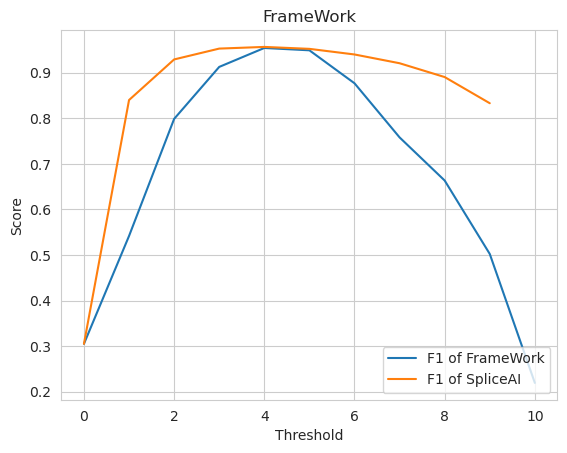

In [92]:
fw_threshold = 0
sa_threshold = 0.5

cm = confusion_matrix(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])
cm2 = confusion_matrix(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])

tn, fp, fn, tp = cm.flatten()
tn2, fp2, fn2, tp2 = cm2.flatten()

print(f"FW: tn={tn}, fp={fp}, fn={fn}, tp={tp}")
print(f"SA: tn={tn2}, fp={fp2}, fn={fn2}, tp={tp2}")
print("")

# fw_score: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), precision_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), recall_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), f1_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])]
# sa_score: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), precision_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), recall_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), f1_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])]

# summary = pd.DataFrame([fw_score, sa_score], columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['FrameWork', 'SpliceAI'])
# print(summary)

fw_accuracy: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_precision: list = [precision_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_recall: list = [recall_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_f1: list = [f1_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]

sa_accuracy: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_precision: list = [precision_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_recall: list = [recall_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_f1: list = [f1_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]


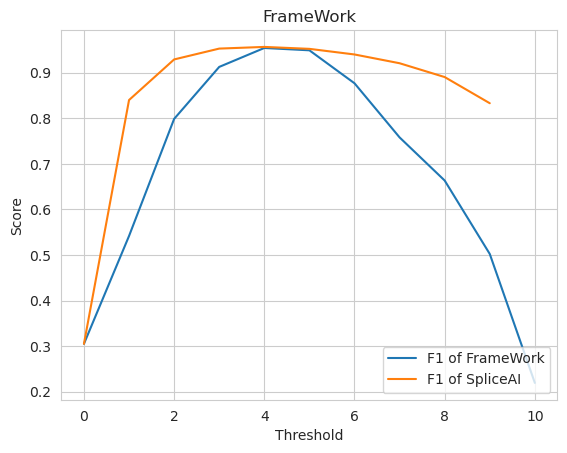

In [104]:

plt.figure()
# plt.plot(fw_accuracy, label='Accuracy of FrameWork')
# plt.plot(fw_precision, label='Precision of FrameWork')
# plt.plot(fw_recall, label='Recall of FrameWork')
plt.plot(fw_f1, label='F1 of FrameWork')

# plt.plot(sa_accuracy, label='Accuracy of SpliceAI')
# plt.plot(sa_precision, label='Precision of SpliceAI')
# plt.plot(sa_recall, label='Recall of SpliceAI')
plt.plot(sa_f1, label='F1 of SpliceAI')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FrameWork')
plt.legend(loc="lower right")
plt.show()

